In [1]:
import numpy as np

In [2]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 11.54 MiB/s, done.


In [3]:
import pickle
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [4]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len, gap=1):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
def make_ready_data(data, train=True, gap=1):
    x_len = 10  # 10 historical time steps
    y_len = 1  # next step
    
    x, y = build_data(data[:, :, 0], x_len, y_len, gap)
    x, y = x.reshape(x.shape[0], 10, 7), y.reshape(y.shape[0], 7)
    
    if train:
        xtrain = x[:60000]
        ytrain = y[:60000]
        xval = x[60000:]
        yval = y[60000:]
    
        return xtrain, xval, ytrain, yval
    else:
        return x, y

train_data = data['train']
test_data = data['test']

xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=1)
xtest, ytest = make_ready_data(test_data, train=False, gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 7),
 (10116, 10, 7),
 (60000, 7),
 (10116, 7),
 (10860, 10, 7),
 (10860, 7))

In [5]:
import torch

def build_dl(xtrain, xval, xtest, ytrain, yval, ytest):
    """convert arrays to tensors"""
    batch_size = 32
    xtrain = torch.Tensor(xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)
    xtest = torch.Tensor(xtest).to(device)
    ytest = torch.Tensor(ytest).to(device)
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_data = torch.utils.data.TensorDataset(xval, yval)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(xtest, ytest)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    
    return train_iter, val_iter, test_iter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

In [6]:
from torch import nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 10
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))

        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        #hn = hn.view(-1, self.hidden_size*2)
        out = lstm_out[:, -1, :]
        out = self.linear(out)
    
        return out

In [8]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss


"""Train loop"""
def run_train(model, num_epochs=20):
    for epoch in range(num_epochs):
        losses = []
    
        for x, y in train_iter:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        val_loss = validate(model) 
    
        if epoch % 2 == 0:
            print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)
                  
    return model

input_size = output_size = 7
hidden_size = 16
num_layers = 1
lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

Epoch:  1 , Train Loss:  0.0028548013411462307 , Val Loss:  0.0026151056
Epoch:  3 , Train Loss:  0.00244377117936189 , Val Loss:  0.0027186573
Epoch:  5 , Train Loss:  0.002402994222721706 , Val Loss:  0.0026334878
Epoch:  7 , Train Loss:  0.0023783002538916966 , Val Loss:  0.0025629022
Epoch:  9 , Train Loss:  0.002362102174262206 , Val Loss:  0.0025124087
Epoch:  11 , Train Loss:  0.0023493429916289946 , Val Loss:  0.002481049
Epoch:  13 , Train Loss:  0.002338495156634599 , Val Loss:  0.002456676
Epoch:  15 , Train Loss:  0.002329086220668008 , Val Loss:  0.0024361575
Epoch:  17 , Train Loss:  0.0023214308926835657 , Val Loss:  0.0024232469
Epoch:  19 , Train Loss:  0.0023151021815215546 , Val Loss:  0.0024148915


In [9]:
"""Test data predictions"""
def run_test(model):
    model.eval()
    y_preds = list()
    y_true = list()

    max_wind = scaler['feature_max_train'][0]
    min_wind = scaler['feature_min_train'][0]

    with torch.no_grad():
        for x, y in test_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
            y = y * max_wind + min_wind
            y_pred = y_pred * max_wind + min_wind
            y_preds.extend(list(y_pred))
            y_true.extend(list(y))
        
    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
    y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)
    
    return y_true, y_preds

y_true, y_preds = run_test(lstm_model)

RMSE:  12.021487
MAE:  9.158315


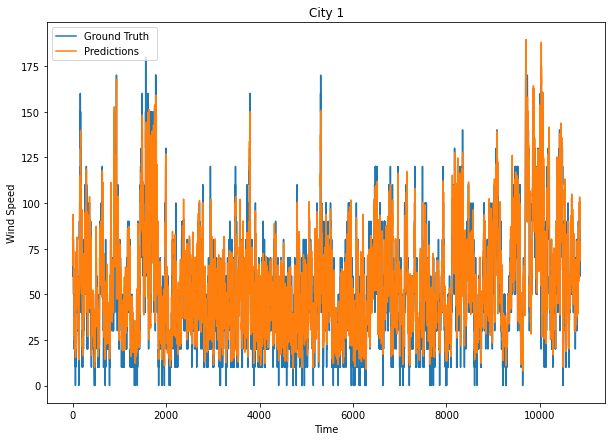

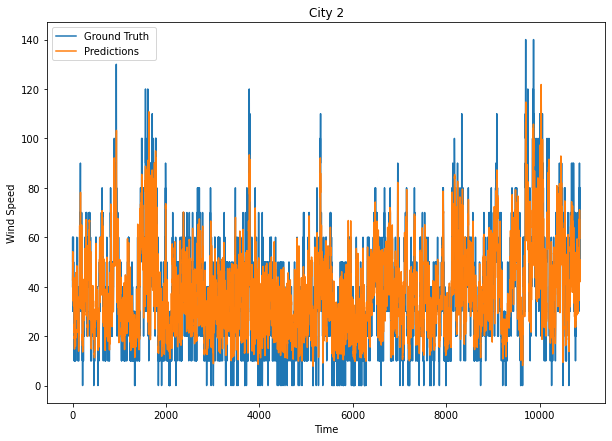

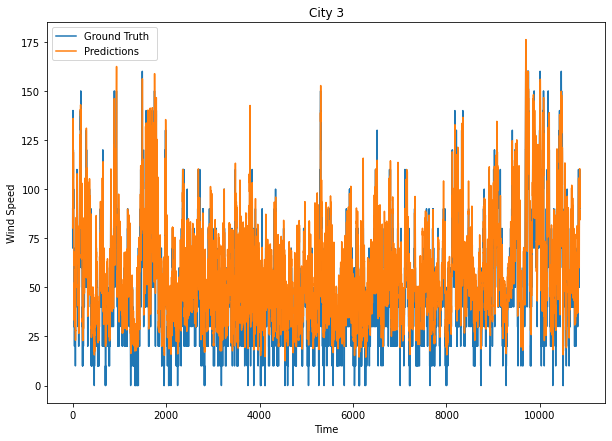

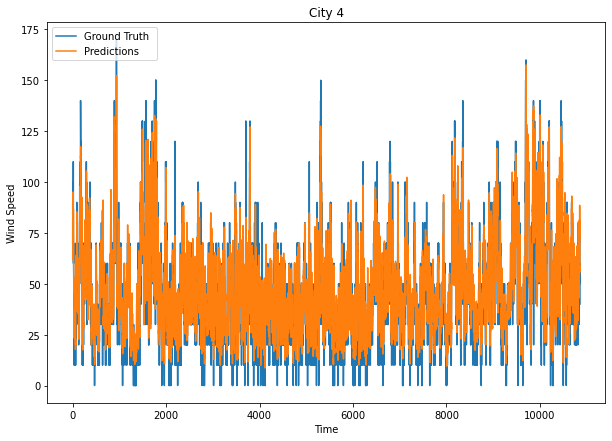

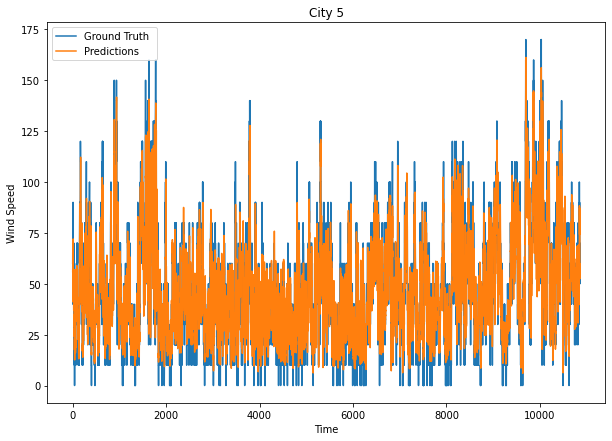

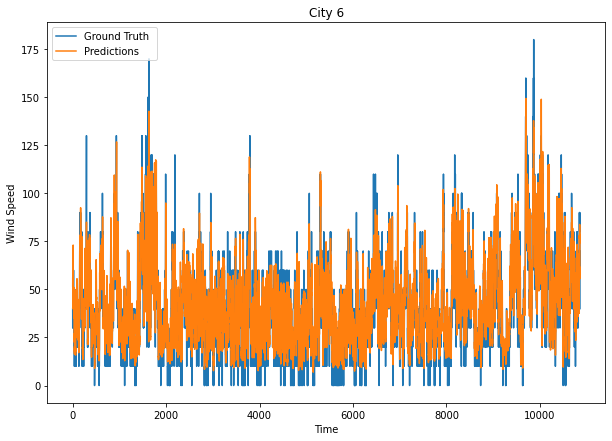

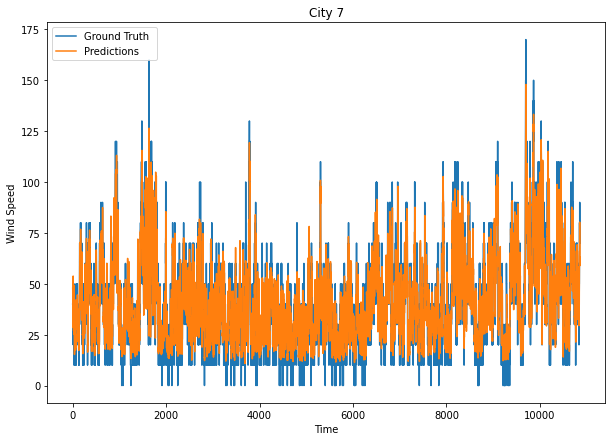

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def results(y_true, y_preds, plots=True):
    """Visualization of windspeed predictions vs ground truth and
    Overall evaluation the predictions of the test data"""
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
    print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

    if plots:
        for i in range(7):
            plt.figure(figsize=(10,7))
            plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
            plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
            plt.title('City '+str(i+1))
            plt.xlabel('Time')
            plt.ylabel('Wind Speed')
            plt.legend(loc="upper left")
            plt.show()
        
results(y_true, y_preds, plots=True)

## 5 hours ahead

In [11]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=5)
xtest, ytest = make_ready_data(test_data, train=False, gap=5)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)
print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.00613709182596455 , Val Loss:  0.0053406195
Epoch:  3 , Train Loss:  0.0055611107117806875 , Val Loss:  0.0052645523
Epoch:  5 , Train Loss:  0.0053940626131991545 , Val Loss:  0.005191607
Epoch:  7 , Train Loss:  0.005338571952159206 , Val Loss:  0.005135065
Epoch:  9 , Train Loss:  0.005306784361414611 , Val Loss:  0.0056672874
Epoch:  11 , Train Loss:  0.005241986805386841 , Val Loss:  0.0052483445
Epoch:  13 , Train Loss:  0.005230862584616989 , Val Loss:  0.005497288
Epoch:  15 , Train Loss:  0.005181345367059112 , Val Loss:  0.0055635283
Epoch:  17 , Train Loss:  0.005206438707374036 , Val Loss:  0.005187989
Epoch:  19 , Train Loss:  0.005172433307953179 , Val Loss:  0.0050968295
Test Data:
RMSE:  17.750574
MAE:  13.7245865


## 10 hours ahead

In [12]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=10)
xtest, ytest = make_ready_data(test_data, train=False, gap=10)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.008511768463564415 , Val Loss:  0.0074878447
Epoch:  3 , Train Loss:  0.007909920556098222 , Val Loss:  0.007454609
Epoch:  5 , Train Loss:  0.007837744209604959 , Val Loss:  0.007456203
Epoch:  7 , Train Loss:  0.007805274774134159 , Val Loss:  0.0074600345
Epoch:  9 , Train Loss:  0.007790227964520454 , Val Loss:  0.0074650557
Epoch:  11 , Train Loss:  0.007783083213617405 , Val Loss:  0.0074718604
Epoch:  13 , Train Loss:  0.007779910183822116 , Val Loss:  0.007480475
Epoch:  15 , Train Loss:  0.007778649944563707 , Val Loss:  0.0074898745
Epoch:  17 , Train Loss:  0.007778538043672839 , Val Loss:  0.0074981623
Epoch:  19 , Train Loss:  0.007779082944492499 , Val Loss:  0.007504765
Test Data:
RMSE:  21.94524
MAE:  17.427301


## 50 hours ahead

In [13]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=50)
xtest, ytest = make_ready_data(test_data, train=False, gap=50)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.010181065759745736 , Val Loss:  0.009296837
Epoch:  3 , Train Loss:  0.00962902028206736 , Val Loss:  0.008990447
Epoch:  5 , Train Loss:  0.009534126616703968 , Val Loss:  0.008979861
Epoch:  7 , Train Loss:  0.009490967493504286 , Val Loss:  0.008988472
Epoch:  9 , Train Loss:  0.009472788824451467 , Val Loss:  0.008996329
Epoch:  11 , Train Loss:  0.009463708836274842 , Val Loss:  0.0090026185
Epoch:  13 , Train Loss:  0.009457845583433907 , Val Loss:  0.009006333
Epoch:  15 , Train Loss:  0.009453213930875063 , Val Loss:  0.009008168
Epoch:  17 , Train Loss:  0.009449206905004878 , Val Loss:  0.0090092635
Epoch:  19 , Train Loss:  0.009445593728745977 , Val Loss:  0.009010315
Test Data:
RMSE:  24.391718
MAE:  19.096544


## References:
- Dataset from "Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks"